In [17]:
%load_ext autoreload
%autoreload 2

import re
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import src.utils.data_utils as data_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classification using keywords

## Chunk Processing

In [2]:
def detect_collaboration(text,
                         collaboration_patterns=None):
    """
    Detect if the text indicates a collaboration.

    Args:
        text (str): Text to analyze.
        collaboration_patterns (list): List of regex patterns to detect collaborations.

    Returns:
        bool: True if collaboration is detected, False otherwise.
    """
    # Default collaboration patterns
    if collaboration_patterns is None:
        collaboration_patterns = [r'\bfeat\b', r'\bft\b', r'\bfeaturing\b', r'\bx\b', r'\bw/\b', r'\bft\.\b']

    # Combine patterns into a single regex pattern
    pattern = re.compile('|'.join(collaboration_patterns), flags=re.IGNORECASE)
    
    return bool(pattern.search(text))

In [3]:
def preprocess_collaborations(chunk_df, collaboration_patterns=None):
    """
    Preprocess a chunk of data

    Args:
        chunk_df (pd.DataFrame): Chunk of data
        collaboration_patterns (list): List of regex patterns to detect collaborations.

    Returns:
        pd.DataFrame: Processed data
    """    
    # Drop rows with missing values
    chunk_df = chunk_df.dropna(how='any')
    
    # Only keep Music and Entertainment categories with selected columns
    chunk_df = chunk_df[chunk_df['categories'].isin(['Music','Entertainment'])]
    columns_to_keep = ['categories', 'title', 'description', 'tags', 'view_count',  'like_count', 'dislike_count', 'channel_id',]
    chunk_df = chunk_df[columns_to_keep]
    
    # Only keep rows where the title indicates a collaboration
    chunk_df = chunk_df[chunk_df['title'].apply(detect_collaboration)]

    return chunk_df

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following 2 cells test the `detect_collaboration` function and the `preprocess_collaborations` function.

</div>

In [4]:
# Test the data processing function

# Load a chunk of data
data_file = 'data/yt_metadata.jsonl.gz'
test_data = pd.read_json(data_file, lines=True, compression="gzip", nrows=100_000)

# Preprocess the data
processed_df = preprocess_collaborations(test_data)
processed_df[['title', 'categories','description', 'tags']]

,title,categories,description,tags
3220,BRAVE | Boom Beach | Bootramp feat Kosteofficial,Music,Thank you Nordic Screens Norway for giving me ...,"official,music,boom beach,boom beach song,boom..."
3631,Filmy Ghost - Labyrinth of Silhouettes (feat M...,Music,Subscribe for more horror music: https://www.y...,"horror music,best horror music,scary music,cre..."
3723,Shamsiel - Tetramorph (feat. Melul) | Creepy E...,Music,Subscribe for more horror music: https://www.y...,"horror music,best horror music,scary music,cre..."
3775,Sílení - X-1 | Eerie Dark Ambient Soundscape,Music,Subscribe for more horror music: https://www.y...,"Sílení,X-1,eerie music,dark music,dark ambient..."
3776,Aram 17 - Ancestors Of Ghosts (Feat. Moloch Co...,Music,Subscribe for more horror music: https://www.y...,"Aram 17,Ancestors Of Ghosts,Moloch Conspiracy,..."
...,...,...,...,...
98928,After Shah Rukh Khan & Amitabh Bachchan | Ranv...,Entertainment,"Ranveer Singh, Vaani Kapoor and others were se...","ranveer singh,befikre,vaani kapoor,Ranveer Sin..."
98939,Jagga Jasoos Sneak Peek Featuring Ranbir Kapoor,Entertainment,Ranbir Kapoor and Katrina Kaif's 'Jagga Jasoos...,"ranbir kapoor,katrina kaif,ranbir kapoor break..."
99445,"Global Citizen Festival In India Ft. Coldplay,...",Entertainment,"On the occasion of World Toilet Day, the first...","bollywood hungama,bollywood hungama interviews..."
99636,Vishal Shekhar featuring The Vamps | Beliya | ...,Entertainment,"Beliya"" was written by Vishal Dadlani, Shekhar...","thevamps,beliya,visha,shekar,Virgin EMI,Bottom..."


## Process the whole dataset

In [5]:
def process_data(file_path, chunk_size, preprocess_func, output_path, collaboration_patterns=None):
    """
    Process a JSONL file in chunks and apply a preprocessing function to each chunk.

    Args:
        file_path (str): Path to the gzipped JSONL file.
        chunk_size (int): Number of rows to process per chunk.
        preprocess_func (callable): Function to apply to each chunk of data (Pandas DataFrame).
        output_path (str): Path to store the processed data.
        collaboration_patterns (list): List of regex patterns to detect collaborations.

    Returns:
        None
    """
    with pd.read_json(file_path, lines=True, compression="gzip", chunksize=chunk_size) as reader:
        for chunk_df in reader:
            # Apply preprocessing function to the chunk
            processed_df = preprocess_func(chunk_df)
            
            # Append the processed chunk to the output file
            processed_df.to_json(output_path, orient="records", lines=True, 
                                 force_ascii=False, compression='gzip', mode='a')

In [6]:
# Define the input and output paths
data_file = 'data/yt_metadata.jsonl.gz'
output_path = 'data/collaborations.jsonl.gz'
chunk_size = 100_000

In [7]:
# Process the data (this may take ~30 minutes) 
# process_data(data_file, chunk_size, preprocess_collaborations, output_path)

## Open the processed data

In [8]:
# Load the processed data and display the first few rows
df_collaborations = pd.read_json('data/collaborations.jsonl.gz', lines=True, compression='gzip')
df_collaborations.head()

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id
0,Music,BRAVE | Boom Beach | Bootramp feat Kosteofficial,Thank you Nordic Screens Norway for giving me ...,"official,music,boom beach,boom beach song,boom...",41416,1193,112,UCzWfqsjlvzAOUozsGFR3kbg
1,Music,Filmy Ghost - Labyrinth of Silhouettes (feat M...,Subscribe for more horror music: https://www.y...,"horror music,best horror music,scary music,cre...",1953,114,1,UCzWdpFOflXTOk5Gsi2aJ67g
2,Music,Shamsiel - Tetramorph (feat. Melul) | Creepy E...,Subscribe for more horror music: https://www.y...,"horror music,best horror music,scary music,cre...",911,35,0,UCzWdpFOflXTOk5Gsi2aJ67g
3,Music,Sílení - X-1 | Eerie Dark Ambient Soundscape,Subscribe for more horror music: https://www.y...,"Sílení,X-1,eerie music,dark music,dark ambient...",514,23,2,UCzWdpFOflXTOk5Gsi2aJ67g
4,Music,Aram 17 - Ancestors Of Ghosts (Feat. Moloch Co...,Subscribe for more horror music: https://www.y...,"Aram 17,Ancestors Of Ghosts,Moloch Conspiracy,...",945,24,0,UCzWdpFOflXTOk5Gsi2aJ67g


In [9]:
# Display the number of collaborations in each category
df_collaborations.value_counts('categories')

categories
Music            707007
Entertainment    226951
Name: count, dtype: int64

## Are collaborations more prone to greater viewership and engagement? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can start by studying the distribution of the number of views, likes, and dislikes for collaborations in each category.

We can then 
1. Compare the distributions for collaborations between the Music and Entertainment categories.
2. Compare the distributions for collaborations and non-collaborations in each category. 

Point 1. will help us understand if one category has the upper hand when it comes to collaborations. 

Point 2. will help us understand if collaborations are more successful than non-collaborations in each category.

</div>

In [10]:
# We start by creating a dataframe per category
df_music = df_collaborations[df_collaborations['categories'] == 'Music'].copy()
df_entertainment = df_collaborations[df_collaborations['categories'] == 'Entertainment'].copy()

In [11]:
df_music.sample(5)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id
402949,Music,La'eric903- Got My People wit me ft 9tre Stack...,La'eric903- Got My People wit me ft 9tre Stack...,"Street Classic Mixtapes,Got My People wit me,9...",250,7,0,UCUr5TJAYTzzoeAFvuxIXU4g
126803,Music,Andy Irvine w/The Johnny O Band - Ain't Doin' ...,Andy Irvine w/ The Johnny O Band - Ain't Doin'...,"AndyIrvineBass,JohnnyOBand,BassSolo,FunkyBass,...",2669,102,2,UClPrDqLPKrRstg648X-eDVg
891837,Music,Young Trey x Phunk Dawg - Jaws Locked (MUSIC V...,DOWNLOAD ON ITUNES:\nhttps://itunes.apple.com/...,"Str8,Up,Entertainment,Mr_OneNine,Ent,Baton,Rou...",4813,123,17,UC0Em08FZHDXo5CtGSrf-riA
302350,Music,Madness Music x Chemical Bass | Trap and Bass ...,Subscribe to our channel: ⟿ https://goo.gl/GcF...,"trap madness,TrapMadness,Drop mix,legendary dr...",1048,68,1,UCxcqvEDYXembUuewkiNm0RQ
300770,Music,"[FREE DL] Migos x 21 Savage ""Ramen"" (Type Beat...",💰 Purchase Link | Download Link : http://bsta....,"type beat 2018 instrumentals,prod. by horus,TR...",1125,29,0,UCaEPFSC3pPKzUxbZp_06ZfQ


In [12]:
df_entertainment.sample(5)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id
831109,Entertainment,(Free For Profit Use) Gunna X Lil Baby Type Be...,Free for profit beats are back BUT! In order t...,"Free,beat,to,use,for,profit,free,music,youtube...",3077,107,0,UC497Lgn9v0XAvnewqxqDckA
501920,Entertainment,Michael Jackson - I Just Can't Stop Loving You...,No Copyright Infringement Intended***\nFair Us...,"Unofficial Music Video,1M Total Views Special",4946768,54879,1348,UCwM40Do0xuxap2FQFPG8Neg
500771,Entertainment,KILLY - Man Of The Year (ft. JUGHOUSE JOHNNY) ...,KILLY x JUGHOUSE JOHNNY - The Man Track 2 [LOS...,"MusicDaily,MusicDaiiy,mp3,hd,hq,official,music...",3088,74,3,UCNyOQHAxawj3d5NQ_0fPmlw
875973,Entertainment,Pokemon X and Y Let's Play! - Pokemon Y Let's ...,Check Out My Twitter: https://twitter.com/Shin...,"pokemon,shinoworld,gold,pokemonx,and,green,lik...",1340,32,6,UC1WH6kXix3aN0rtFEomkaVQ
69344,Entertainment,TWTR GPRO X CHK Technical Analysis Chart 5/23/...,TWTR GPRO X CHK Technical Analysis Chart for 5...,"trade,stocks chart trading,technical analysis,...",156,2,0,UCnqZ2hx679DqRi6khRUNw2g


### Distribution of views, likes, and dislikes for Music collaborations

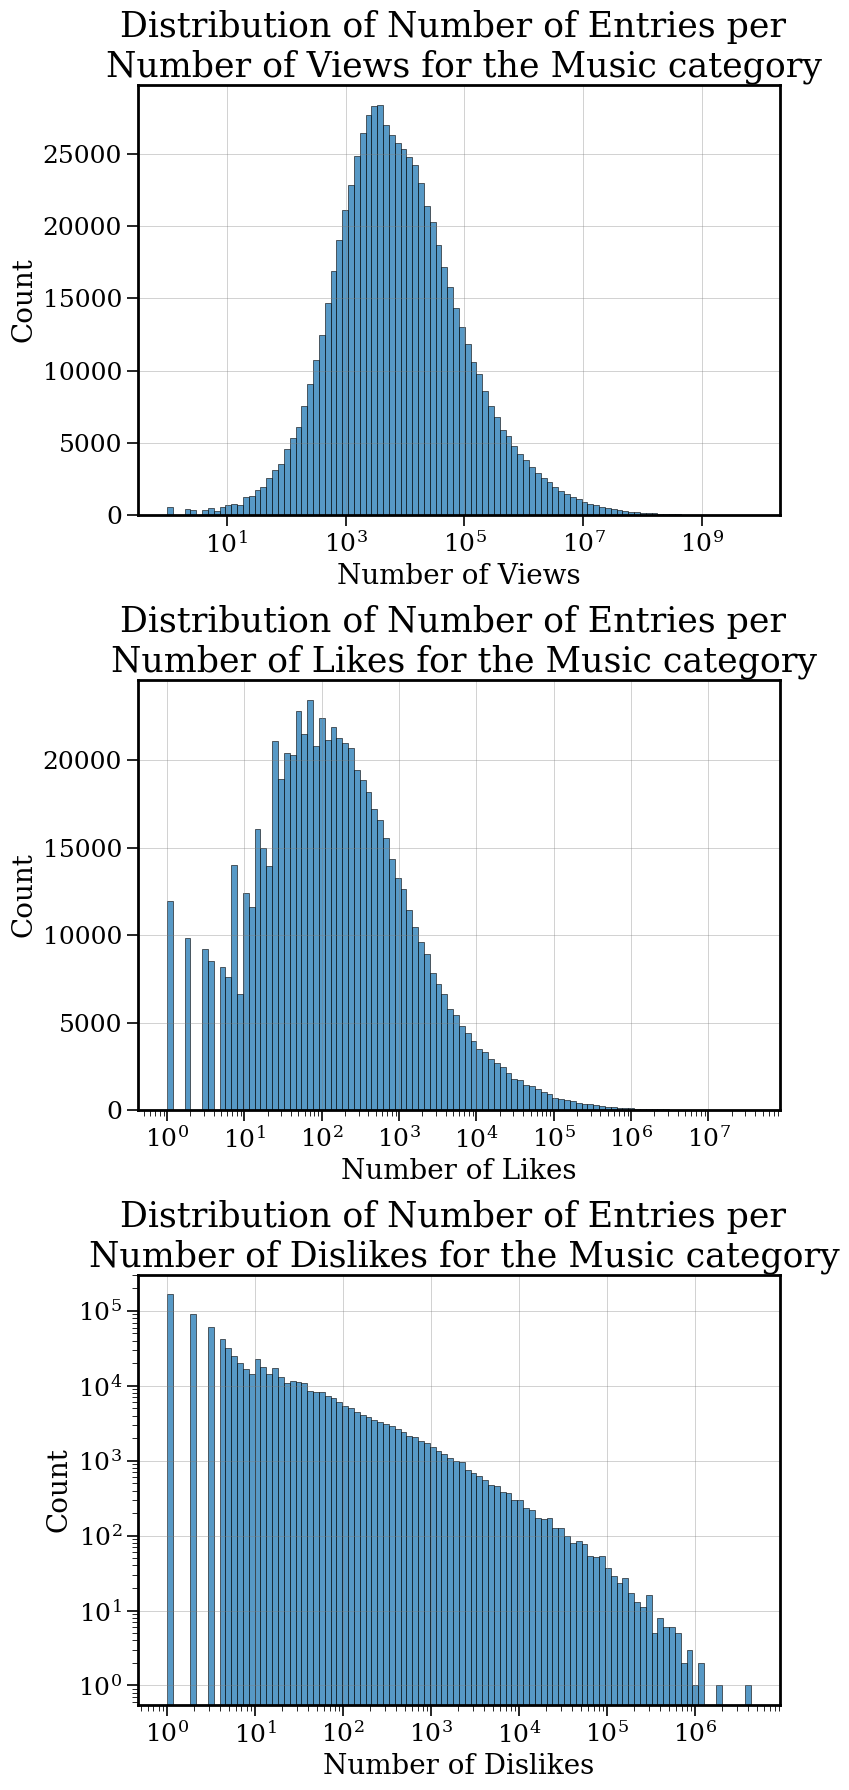

Summary statistics for the ['view_count', 'like_count', 'dislike_count']:
         view_count    like_count  dislike_count
count  7.070070e+05  7.070070e+05   7.070070e+05
mean   6.814420e+05  5.115493e+03   2.290998e+02
std    1.904570e+07  9.887944e+04   7.824047e+03
min    1.000000e+00  1.000000e+00   1.000000e+00
25%    1.459000e+03  3.000000e+01   2.000000e+00
50%    6.360000e+03  1.250000e+02   4.000000e+00
75%    3.492200e+04  6.020000e+02   1.700000e+01
max    6.509934e+09  3.528733e+07   4.265884e+06


In [13]:
data_utils.plot_category_distribution(df_data=df_music,
                                      columns=["view_count", "like_count", "dislike_count"],
                                      category="Music",
                                      x_logs=[True, True, True],
                                      y_logs=[False, False, True],
                                      kind="hist",
                                      print_summary=True)

### Distribution of views, likes, and dislikes for Entertainment collaborations

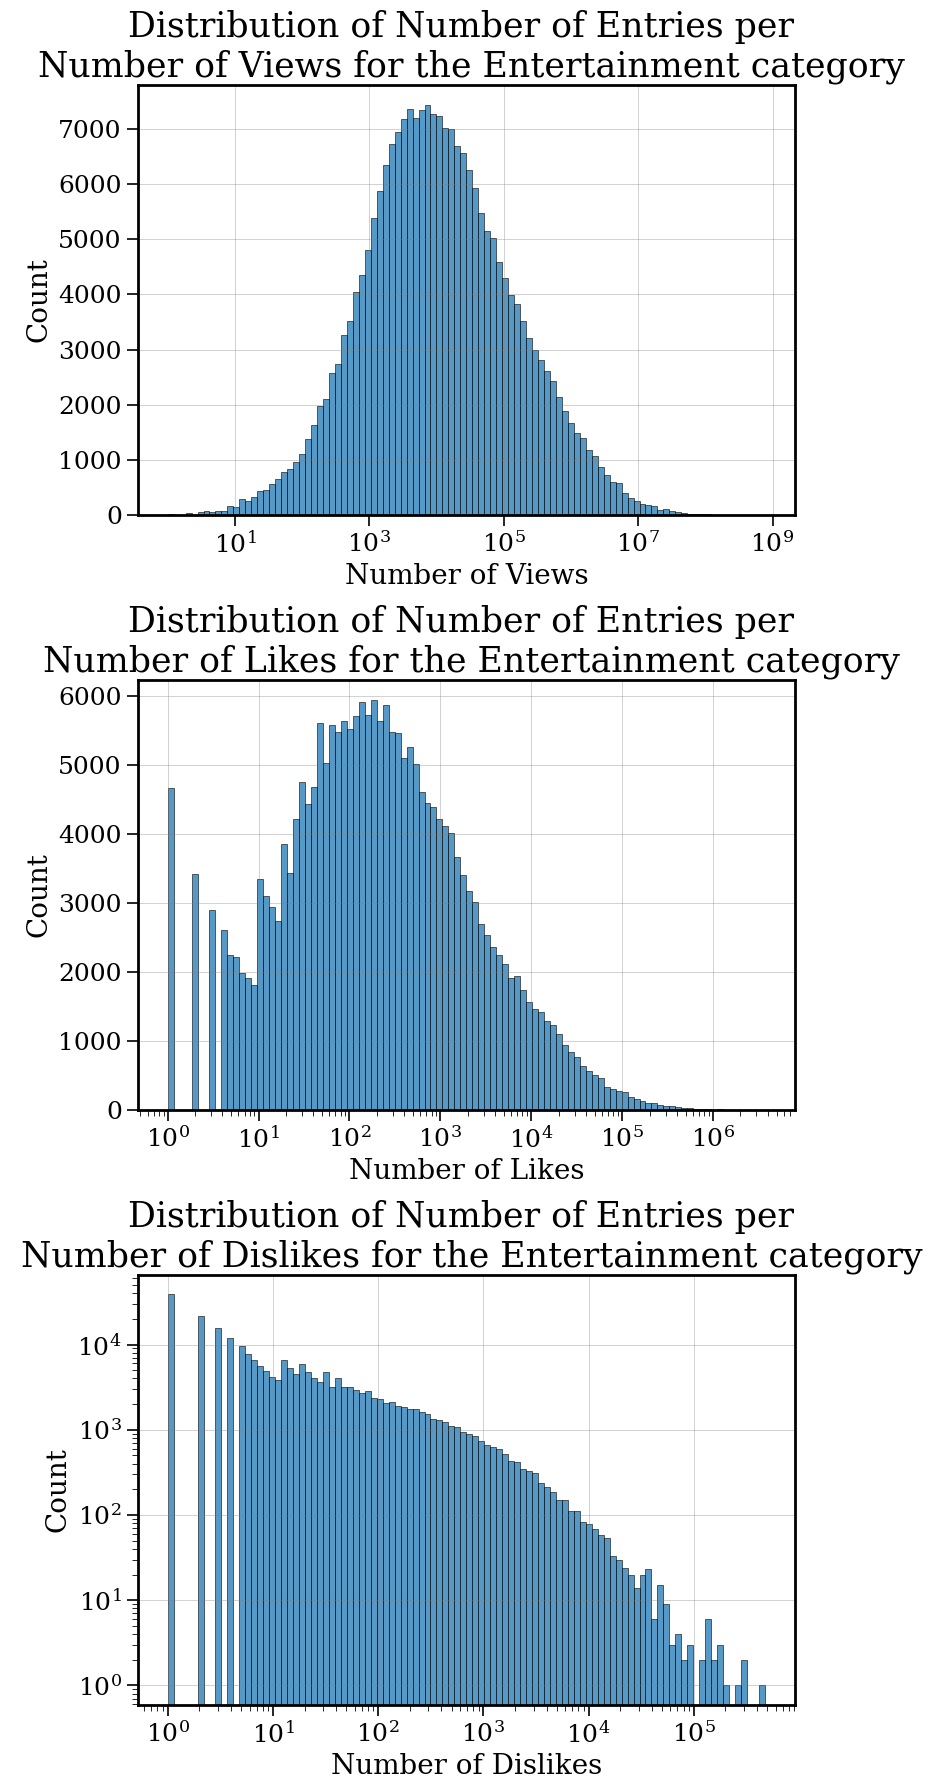

Summary statistics for the ['view_count', 'like_count', 'dislike_count']:
         view_count    like_count  dislike_count
count  2.269510e+05  2.269510e+05  226951.000000
mean   3.117725e+05  3.641422e+03     167.945742
std    3.451132e+06  2.852296e+04    2225.098664
min    1.000000e+00  1.000000e+00       1.000000
25%    1.906000e+03  3.800000e+01       2.000000
50%    9.630000e+03  1.800000e+02       8.000000
75%    5.841650e+04  9.510000e+02      35.000000
max    7.714678e+08  3.716088e+06  474708.000000


In [14]:
data_utils.plot_category_distribution(df_data=df_entertainment,
                                      columns=["view_count", "like_count", "dislike_count"],
                                      category="Entertainment",
                                      x_logs=[True, True, True],
                                      y_logs=[False, False, True],
                                      kind="hist",
                                      print_summary=True)

### Comparison of views, likes, and dislikes between Music and Entertainment collaborations

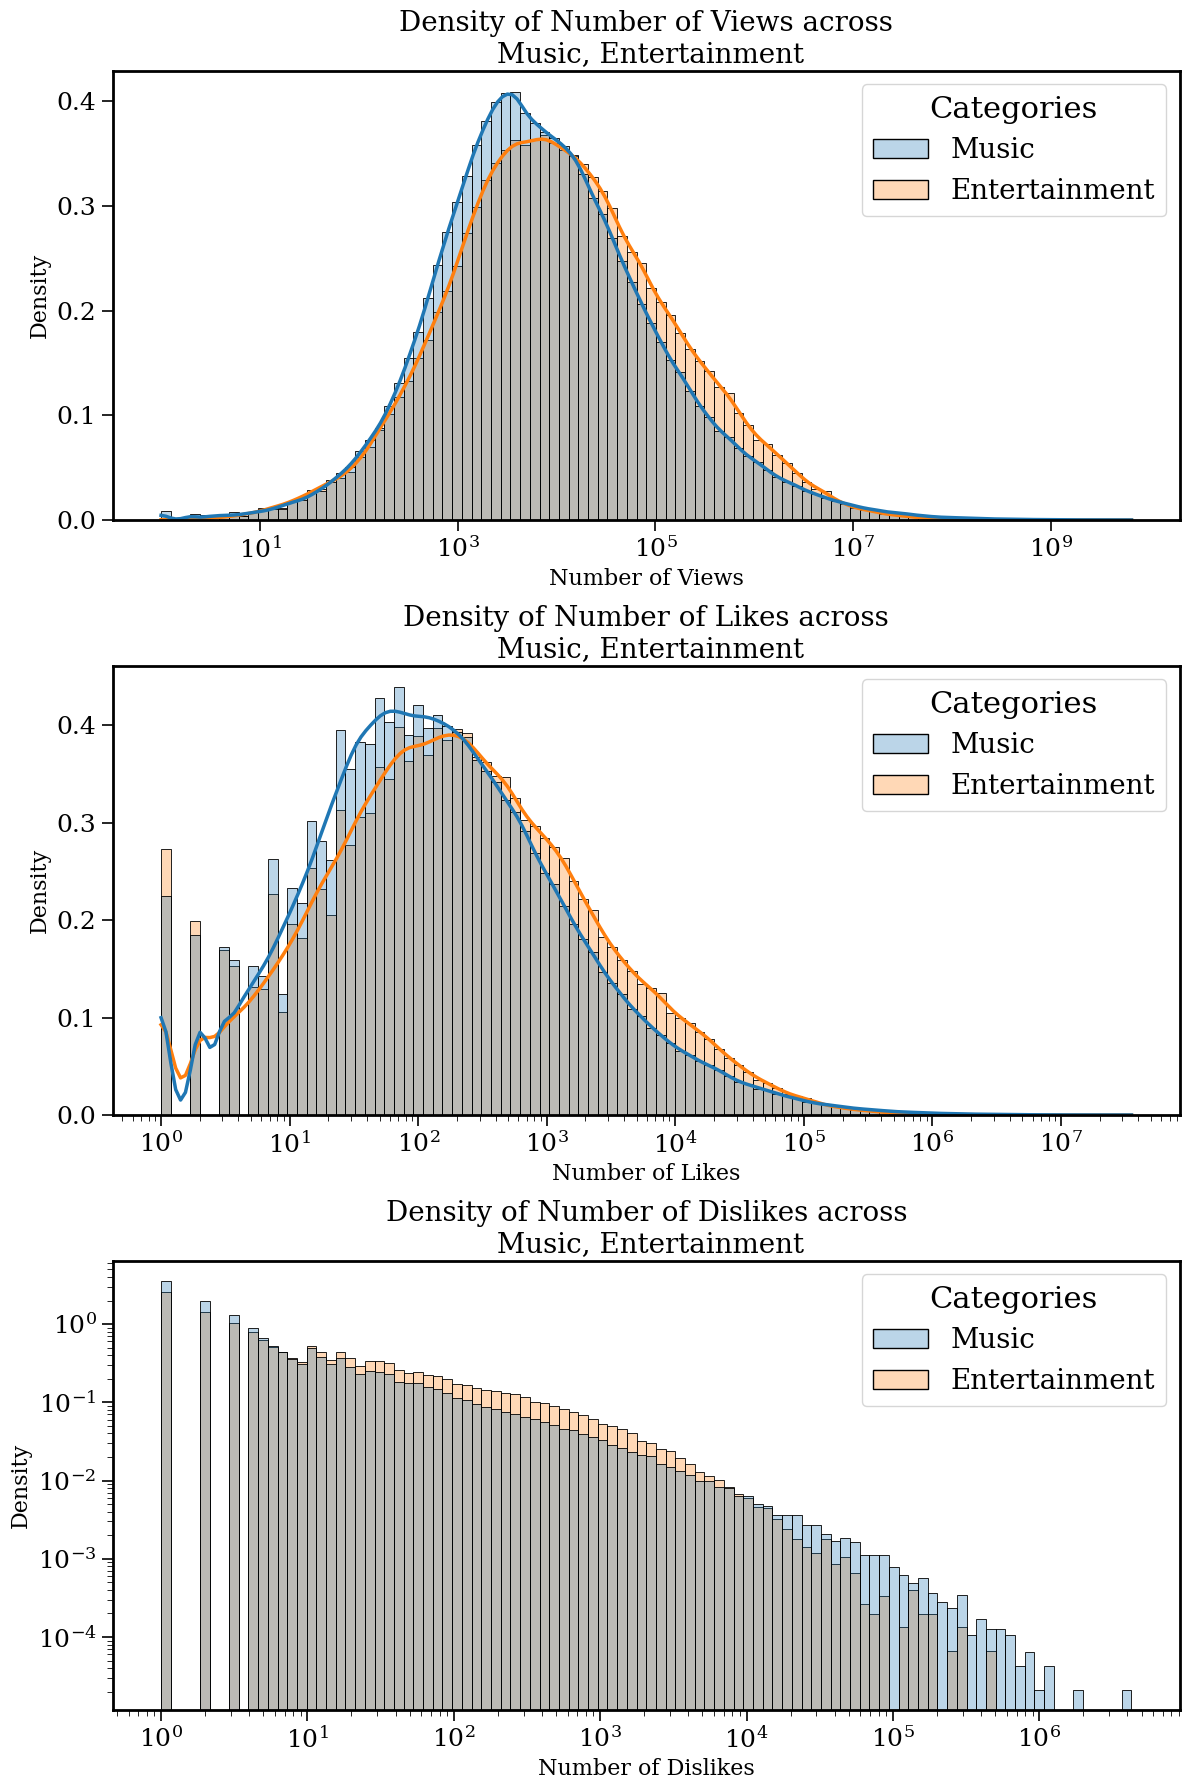

In [15]:
categories = ["Music", "Entertainment"]
data_utils.compare_distribution_across_categories(df_collaborations,
                                                  columns=["view_count", "like_count", "dislike_count"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[True, True, True],
                                                  y_logs=[False, False, True],
                                                  kind="hist",
                                                  marker_only=False, 
                                                  density=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:**

- The distribution of views for the Music category seems to be slightly skewed to the left compared to the Entertainment category. 

- A similar observation can be made for the distribution of likes. 

- The distribution of dislikes seems almost power-law distributed for the Music category. The Entertainment distribution is a bit more "rounded". 

In each case, since we log-transformed the x-axis, we can look at the geometric mean to compare the two categories.

</div>

In [52]:
# Compute both geometric and arithmetic means for each category
columns = ["view_count", "like_count", "dislike_count"]

music_gmeans = {col: data_utils.geometric_mean(df_music[col]) for col in columns}
entertainment_gmeans = {col: data_utils.geometric_mean(df_entertainment[col]) for col in columns}

music_means = {col: df_music[col].mean() for col in columns}
entertainment_means = {col: df_entertainment[col].mean() for col in columns}

# Display the comparison in a unified table
print("Comparison of geometric and arithmetic Means for Music and Entertainment Categories:\n")
print(f"{'Metric':<20} {'Music (Geometric)':<20} {'Entertainment (Geometric)':<30} {'Music (Arithmetic)':<20} {'Entertainment (Arithmetic)':<20}")
print("-" * 120)

for col in columns:
    music_geo = music_gmeans[col]
    music_arith = music_means[col]
    ent_geo = entertainment_gmeans[col]
    ent_arith = entertainment_means[col]
    print(f"{col:<20} {music_geo:<20.2f} {ent_geo:<30.2f} {music_arith:<20.2f} {ent_arith:<20.2f}")

Comparison of geometric and arithmetic Means for Music and Entertainment Categories:

Metric               Music (Geometric)    Entertainment (Geometric)      Music (Arithmetic)   Entertainment (Arithmetic)
------------------------------------------------------------------------------------------------------------------------
view_count           7716.97              10885.06                       681441.02            311771.52           
like_count           145.24               194.23                         5114.49              3640.42             
dislike_count        6.58                 10.81                          228.10               166.95              


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**

- When looking at the geometric means, the Entertainment category seems to have the upper hand in terms of views and likes (as can be seen from the distributions).
- Interestingly, when looking at the arithmetic means (that might be ill-defined), the Music category seems to have higher values for views and likes. This is probably due to the presence of **stronger outliers in the Music category**. 

</div>

# Classification using a Zero-Shot Model

In [16]:
# from transformers import pipeline
# 
# def is_significant(collab_score, non_collab_score, threshold=0.1):
#     """
#     Check if the difference between two scores is significant.
# 
#     Args:
#         collab_score (float): Score for the collaboration label.
#         non_collab_score (float): Score for the non-collaboration label.
#         threshold (float): Minimum difference to consider the scores significant.
# 
#     Returns:
#         bool: True if the scores are significant, False otherwise.
#     """
#     return abs(collab_score - non_collab_score) > threshold
# 
# 
# MODEL_PATH = 'src/models/zero-shot-classification'
# 
# # Load the zero-shot classification model
# classifier = pipeline("src/models/zero-shot-classification", model="facebook/bart-large-mnli")
# 
# # Save the model to disk
# model_path = "src/models/zero-shot-classification"
# classifier.save_pretrained(model_path)
# 
# # Labels for the zero-shot classification model
# music_collab_labels = ['multiple artists']
# music_non_collab_labels = ['a single artist']
# music_labels = music_collab_labels + music_non_collab_labels
# 
# # Hypothesis template for the zero-shot classification model
# music_hypothesis_template = "This music is with {}."
# 
# texts = ["Radiohead live at Glastonbury 2003",
#          "The Beatles - Hey Jude", 
#          "Best of Debussy",
#          "HAYATO SUMINO – third round (18th Chopin Competition, Warsaw)",
#          "LL COOL J - Murdergram Deux ft. Eminem", 
#          "Eminem - Love The Way You Lie ft. Rihanna"
#          ]
# 
# for text in texts:
#     result = classifier(
#         text,
#         candidate_labels=music_labels,
#         hypothesis_template=music_hypothesis_template,
#         multi_label=False,
#     )
# 
#     # Extract scores for collaboration and non-collaboration labels
#     collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_collab_labels])
#     non_collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_non_collab_labels])
# 
#     total_collab_score = collab_scores.sum()
#     total_non_collab_score = non_collab_scores.sum()
# 
#     # Check if the scores are significant
#     if is_significant(total_collab_score, total_non_collab_score, threshold=0.5):
#         # Décider de la catégorie basée sur le score maximal
#         if total_collab_score > total_non_collab_score:
#             prediction = "Collaborative"
#         else:
#             prediction = "Non-Collaborative"
#     else:
#         continue
# 
#     print(f"Text: {text}. "
#           f"\n    - Predicted category: {prediction}, "
#           f"\n    - collab_score: {total_collab_score}, "
#           f"\n    - non_collab_score: {total_non_collab_score}")